# Baseline Sound Event Detection (SED)


As a first task, we try to only detect events in each audio frame. Since
multiple events can occur at the same time, we are working with _Polyphonic
Sound Event Detection_ (Polyphonic SED).


In [1]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F

from datasets import VariableLengthDataset, collate_fn
from seld_net import SELDNetBackbone

FEATURES_DIR = 'data/features_dev'
SAMPLE_RATE = 24000
FRAME_LENGTH = SAMPLE_RATE // 10
MAX_EVENTS = 5
NUM_CLASSES = 13

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
augments = [2]
train_dataset = VariableLengthDataset(FEATURES_DIR, split='train', augments=augments)
test_dataset = VariableLengthDataset(FEATURES_DIR, split='test')

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 90
Test dataset size: 78


torch.Size([7, 64, 4470])
torch.Size([894, 5, 4])


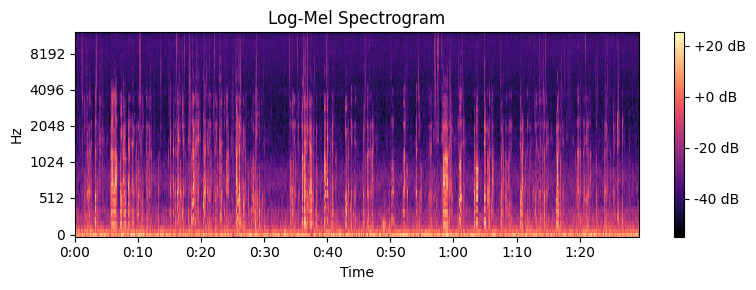

In [3]:
features, labels = train_dataset[0]
print(features.shape)
print(labels.shape)

plt.figure(figsize=(8, 3))
librosa.display.specshow(
    features.numpy()[0],
    sr=SAMPLE_RATE,
    hop_length=SAMPLE_RATE // 50,
    x_axis='time',
    y_axis='mel',
    cmap='magma',
)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()

In [4]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
)

In [5]:
frames = 0
label_classes = set()
class_distribution = torch.zeros(NUM_CLASSES + 1, dtype=torch.int64)

for features, labels, lengths in train_dataloader:
    print(
        list(features.shape),
        list(labels.shape),
        list(lengths.shape),
        f'{features.shape.numel() * features.dtype.itemsize / 1024**2} MB',
    )
    frames += features.shape[0] * features.shape[-1] // 5
    frame_labels = labels[:, :, :, 0].flatten()
    label_classes.update(frame_labels.unique().tolist())
    class_distribution += torch.bincount(frame_labels, minlength=NUM_CLASSES + 1)

print(f'Label classes: {label_classes}')
print(f'Class distribution: {class_distribution}')

class_weights_softmax = class_distribution.max() / class_distribution
class_weights_softmax = class_weights_softmax / class_weights_softmax.sum()

class_distribution = class_distribution[1:]
class_weights_sigmoid = frames / class_distribution - 1

[8, 7, 64, 14830] [8, 2966, 5, 4] [8] 202.75390625 MB
[8, 7, 64, 13155] [8, 2631, 5, 4] [8] 179.853515625 MB
[8, 7, 64, 16830] [8, 3366, 5, 4] [8] 230.09765625 MB
[8, 7, 64, 11790] [8, 2358, 5, 4] [8] 161.19140625 MB
[8, 7, 64, 16270] [8, 3254, 5, 4] [8] 222.44140625 MB
[8, 7, 64, 16095] [8, 3219, 5, 4] [8] 220.048828125 MB
[8, 7, 64, 16755] [8, 3351, 5, 4] [8] 229.072265625 MB
[8, 7, 64, 19430] [8, 3886, 5, 4] [8] 265.64453125 MB
[8, 7, 64, 16420] [8, 3284, 5, 4] [8] 224.4921875 MB
[8, 7, 64, 17735] [8, 3547, 5, 4] [8] 242.470703125 MB
[8, 7, 64, 11210] [8, 2242, 5, 4] [8] 153.26171875 MB
[2, 7, 64, 8015] [2, 1603, 5, 4] [2] 27.39501953125 MB
Label classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Class distribution: tensor([1198769,   44385,   49658,     849,    1529,    5375,   28535,    3319,
           1046,   39863,    4438,     861,    1473,      90])


In [6]:
class SEDNet(nn.Module):
    def __init__(
        self,
        num_classes,
        num_events,
        input_dim,
        hidden_dim,
        dropout,
        rnn_layers,
        mhsa_layers,
        fc_layers,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_events = num_events
        self.dropout = dropout
        self.fc_layers = fc_layers

        self.backbone = SELDNetBackbone(
            num_classes,
            num_events,
            input_dim,
            hidden_dim,
            dropout,
            rnn_layers,
            mhsa_layers,
        )

        fc_dim = hidden_dim * 2
        self.fc = nn.ModuleList()
        for i in range(fc_layers - 1):
            self.fc.append(nn.Linear(fc_dim, hidden_dim))
            fc_dim = hidden_dim

        output_dim = num_classes * num_events
        self.head = nn.Linear(fc_dim, output_dim)

    def forward(self, x, lengths):
        x = self.backbone(x, lengths)

        for i in range(self.fc_layers - 1):
            x = self.fc[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.head(x)
        x = x.reshape(x.shape[0], -1, self.num_events, self.num_classes)
        return x

In [7]:
model_args = {
    'num_classes': NUM_CLASSES,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
    'rnn_layers': 2,
    'mhsa_layers': 2,
    'fc_layers': 1,
}

model = SEDNet(**model_args)
features, _, lengths = next(iter(train_dataloader))
summary(model, input_data=[features, lengths])

Layer (type:depth-idx)                   Output Shape              Param #
SEDNet                                   [8, 2358, 5, 13]          --
├─SELDNetBackbone: 1-1                   [8, 2358, 128]            --
│    └─Sequential: 2-1                   [8, 64, 2, 2358]          --
│    │    └─ConvBlock: 3-1               [8, 64, 16, 2358]         4,224
│    │    └─ConvBlock: 3-2               [8, 64, 4, 2358]          37,056
│    │    └─ConvBlock: 3-3               [8, 64, 2, 2358]          37,056
│    └─GRU: 2-2                          [14084, 128]              148,992
│    └─ModuleList: 2-5                   --                        (recursive)
│    │    └─MultiheadAttention: 3-4      [8, 2358, 128]            66,048
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─LayerNorm: 3-5               [8, 2358, 128]            256
│    └─ModuleList: 2-5                   --                        (recursive)
│    │    └─MultiheadAttention: 3-6  

In [8]:
def eval_predictions(predictions, labels, split='train'):
    """Compute and print evaluation metrics.

    Parameters:
        - predictions: list of predicted labels in {0, 1, ..., NUM_CLASSES}
        - labels: list of true labels in {0, 1, ..., NUM_CLASSES}
    """
    classes = np.arange(1, NUM_CLASSES + 1)
    kwargs = {'labels': classes, 'zero_division': np.nan}
    pr = precision_score(labels, predictions, average='micro', **kwargs)
    re = recall_score(labels, predictions, average='micro', **kwargs)
    f1_micro = f1_score(labels, predictions, average='micro', **kwargs)
    f1_macro = f1_score(labels, predictions, average='macro', **kwargs)

    print(
        f'[{split:5}] Precision: {pr:.2f}, Recall: {re:.2f}, '
        f'F1: {f1_micro:.2f}, F1 (macro): {f1_macro:.2f}'
    )


def valid_logits(outputs, labels, lengths):
    """Compute logits and labels for valid time steps.

    Parameters:
        - outputs: (batch size, time steps, num events, num classes)
        - labels: (batch size, time steps, num events)
        - lengths: (batch size,)

    Returns:
        - logits: (num valid time steps * num events, num classes)
        - labels: (num valid time steps * num events,)
    """
    # Lengths are for features, which are 5 times longer than labels
    lengths = lengths // 5
    device = outputs.device
    num_events, num_classes = outputs.shape[2:]

    # Create mask for valid time steps
    time_indices = torch.arange(outputs.shape[1], device=device)[None, :]
    mask = time_indices < lengths.to(device)[:, None]
    mask = mask[:, :, None].expand(-1, -1, num_events)

    # All tensors of same shape get flattened in the same way
    logits_flat = outputs.reshape(-1, num_classes)
    labels_flat = labels.reshape(-1)
    mask_flat = mask.reshape(-1)

    logits_valid = logits_flat[mask_flat]
    labels_valid = labels_flat[mask_flat]

    return logits_valid, labels_valid


def train_model(
    model_args,
    train_dataloader,
    test_dataloader,
    epochs,
    loss_fn,
):
    model = SEDNet(**model_args).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

    for epoch in range(epochs):
        loss_sum = 0
        train_predictions, train_labels = [], []
        test_predictions, test_labels = [], []

        model.train()
        pbar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{epochs}')
        for j, (features, labels, lengths) in enumerate(train_dataloader):
            # Use only the class labels, lengths must be left on the CPU for
            # RNN's pack_padded_sequence

            # features: (batch size, num features, num mels, time steps)
            # labels: (batch size, time steps, num events)
            features = features.to(device)
            labels = labels[:, :, :, 0].to(device)

            optimizer.zero_grad()

            # outputs: (batch size, time steps, num events, num classes)
            outputs = model(features, lengths)

            loss, predictions, labels = loss_fn(outputs, labels, lengths)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            pbar.set_postfix(loss=loss_sum / (j + 1))
            pbar.update(1)

            train_predictions.append(predictions.numpy(force=True))
            train_labels.append(labels.numpy(force=True))

        model.eval()
        with torch.no_grad():
            test_loss = 0

            for features, labels, lengths in test_dataloader:
                features = features.to(device)
                labels = labels[:, :, :, 0].to(device)
                outputs = model(features, lengths)
                loss, predictions, labels = loss_fn(outputs, labels, lengths)
                test_loss += loss.item()

                test_predictions.append(predictions.numpy(force=True))
                test_labels.append(labels.numpy(force=True))

            pbar.set_postfix(
                loss=loss_sum / len(train_dataloader),
                test_loss=test_loss / len(test_dataloader),
            )
            pbar.close()

        if (epoch + 1) % 10 == 0:
            train_predictions = np.concatenate(train_predictions, axis=0)
            train_labels = np.concatenate(train_labels, axis=0)
            test_predictions = np.concatenate(test_predictions, axis=0)
            test_labels = np.concatenate(test_labels, axis=0)
            eval_predictions(train_predictions, train_labels)
            eval_predictions(test_predictions, test_labels, split='test')

    return model


## Baseline with softmax


In [9]:
def softmax_loss(outputs, labels, lengths, class_weights=None):
    """Compute loss, predictions and labels for the softmax outputs.

    Parameters:
        - outputs: (batch size, time steps, num events, num classes)
        - labels: (batch size, time steps, num events)
        - lengths: (batch size,)

    Returns:
        - loss: Tensor scalar
        - predictions: (num valid time steps * num events,)
        - labels: (num valid time steps * num events,)
    """
    logits, labels = valid_logits(outputs, labels, lengths)

    loss = F.cross_entropy(logits, labels, reduction='mean')
    predictions = logits.argmax(dim=1)

    return loss, predictions, labels


In [ ]:
model_args = {
    # Using softmax, we need another class for no event
    'num_classes': NUM_CLASSES + 1,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
    'rnn_layers': 2,
    'mhsa_layers': 2,
    'fc_layers': 1,
}
train_dataset = VariableLengthDataset(
    FEATURES_DIR,
    split='train',
    augments=[2],
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)
model = train_model(
    model_args,
    train_dataloader,
    test_dataloader,
    200,
    lambda *x: softmax_loss(*x, class_weights=class_weights_softmax),
)
# 19m 0s

Epoch 10/200: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.487, test_loss=0.783]


[train] Precision: 0.55, Recall: 0.41, F1: 0.47, F1 (macro): 0.16
[test ] Precision: 0.36, Recall: 0.31, F1: 0.34, F1 (macro): 0.12


Epoch 20/200: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s, loss=0.361, test_loss=0.739]


[train] Precision: 0.71, Recall: 0.62, F1: 0.66, F1 (macro): 0.33
[test ] Precision: 0.41, Recall: 0.34, F1: 0.37, F1 (macro): 0.17


Epoch 30/200: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s, loss=0.301, test_loss=0.703]


[train] Precision: 0.78, Recall: 0.67, F1: 0.72, F1 (macro): 0.41
[test ] Precision: 0.52, Recall: 0.38, F1: 0.44, F1 (macro): 0.18


Epoch 40/200: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, loss=0.258, test_loss=0.748]


[train] Precision: 0.79, Recall: 0.74, F1: 0.77, F1 (macro): 0.47
[test ] Precision: 0.49, Recall: 0.37, F1: 0.42, F1 (macro): 0.18


Epoch 50/200: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.255, test_loss=0.702]


[train] Precision: 0.80, Recall: 0.74, F1: 0.77, F1 (macro): 0.47
[test ] Precision: 0.50, Recall: 0.44, F1: 0.47, F1 (macro): 0.22


Epoch 60/200: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.258, test_loss=0.716]


[train] Precision: 0.81, Recall: 0.72, F1: 0.76, F1 (macro): 0.49
[test ] Precision: 0.49, Recall: 0.43, F1: 0.45, F1 (macro): 0.21


Epoch 70/200: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s, loss=0.2, test_loss=0.728]


[train] Precision: 0.85, Recall: 0.78, F1: 0.81, F1 (macro): 0.59
[test ] Precision: 0.48, Recall: 0.38, F1: 0.42, F1 (macro): 0.21


Epoch 80/200: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s, loss=0.205, test_loss=0.734]


[train] Precision: 0.84, Recall: 0.78, F1: 0.81, F1 (macro): 0.60
[test ] Precision: 0.50, Recall: 0.42, F1: 0.46, F1 (macro): 0.24


Epoch 90/200: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.189, test_loss=0.786]


[train] Precision: 0.84, Recall: 0.79, F1: 0.82, F1 (macro): 0.62
[test ] Precision: 0.53, Recall: 0.43, F1: 0.48, F1 (macro): 0.21


Epoch 100/200: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s, loss=0.18, test_loss=0.671]


[train] Precision: 0.86, Recall: 0.81, F1: 0.84, F1 (macro): 0.64
[test ] Precision: 0.56, Recall: 0.46, F1: 0.51, F1 (macro): 0.28


Epoch 110/200: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s, loss=0.207, test_loss=0.704]


[train] Precision: 0.83, Recall: 0.77, F1: 0.80, F1 (macro): 0.59
[test ] Precision: 0.52, Recall: 0.45, F1: 0.48, F1 (macro): 0.25


Epoch 120/200: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.168, test_loss=0.676]


[train] Precision: 0.87, Recall: 0.82, F1: 0.84, F1 (macro): 0.64
[test ] Precision: 0.55, Recall: 0.47, F1: 0.51, F1 (macro): 0.28


Epoch 130/200: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.185, test_loss=0.691]


[train] Precision: 0.86, Recall: 0.80, F1: 0.83, F1 (macro): 0.63
[test ] Precision: 0.54, Recall: 0.47, F1: 0.50, F1 (macro): 0.28


Epoch 140/200: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.165, test_loss=0.674]


[train] Precision: 0.87, Recall: 0.82, F1: 0.85, F1 (macro): 0.66
[test ] Precision: 0.54, Recall: 0.48, F1: 0.51, F1 (macro): 0.29


Epoch 150/200: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s, loss=0.147, test_loss=0.781]


[train] Precision: 0.88, Recall: 0.84, F1: 0.86, F1 (macro): 0.69
[test ] Precision: 0.52, Recall: 0.43, F1: 0.47, F1 (macro): 0.27


Epoch 160/200: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s, loss=0.146, test_loss=0.713]


[train] Precision: 0.88, Recall: 0.84, F1: 0.86, F1 (macro): 0.70
[test ] Precision: 0.52, Recall: 0.46, F1: 0.49, F1 (macro): 0.30


Epoch 170/200: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.17, test_loss=0.696]


[train] Precision: 0.86, Recall: 0.81, F1: 0.84, F1 (macro): 0.65
[test ] Precision: 0.50, Recall: 0.47, F1: 0.49, F1 (macro): 0.26


Epoch 180/200: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s, loss=0.146, test_loss=0.768]


[train] Precision: 0.88, Recall: 0.84, F1: 0.86, F1 (macro): 0.69
[test ] Precision: 0.53, Recall: 0.46, F1: 0.49, F1 (macro): 0.29


Epoch 190/200: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.153, test_loss=0.715]


[train] Precision: 0.89, Recall: 0.85, F1: 0.87, F1 (macro): 0.71
[test ] Precision: 0.49, Recall: 0.50, F1: 0.49, F1 (macro): 0.30


Epoch 200/200: 100%|██████████| 12/12 [00:05<00:00,  2.36it/s, loss=0.148, test_loss=0.759]

[train] Precision: 0.88, Recall: 0.84, F1: 0.86, F1 (macro): 0.69
[test ] Precision: 0.56, Recall: 0.46, F1: 0.50, F1 (macro): 0.31


## Baseline with sigmoid


In [10]:
def sigmoid_loss(outputs, labels, lengths, class_weights=None):
    """Compute loss, predictions and labels for the sigmoid outputs.

    Parameters:
        - outputs: (batch size, time steps, num events, num classes)
        - labels: (batch size, time steps, num events)
        - lengths: (batch size,)

    Returns:
        - loss: Tensor scalar
        - predictions: (num valid time steps * num events,)
        - labels: (num valid time steps * num events,)
    """
    logits, labels = valid_logits(outputs, labels, lengths)
    limits = torch.tensor([1], device=device), torch.tensor([1000], device=device)

    loss = 0
    for i in range(NUM_CLASSES):
        gt = (labels == (i + 1)).sum()
        w = torch.clamp((len(labels) - gt) / gt, *limits) / 2
        cls_loss = F.binary_cross_entropy_with_logits(
            logits[:, i],
            (labels == (i + 1)).float(),
            reduction='mean',
            pos_weight=w,
        )
        loss += cls_loss

    class_indicators = torch.arange(1, NUM_CLASSES + 1, device=device)

    predictions = (F.sigmoid(logits) > 0.5) * class_indicators
    labels = (labels[:, None] == class_indicators[None, :]) * class_indicators
    predictions = predictions.flatten()
    labels = labels.flatten()

    return loss, predictions, labels

In [ ]:
model_args = {
    'num_classes': NUM_CLASSES,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
    'rnn_layers': 2,
    'mhsa_layers': 2,
    'fc_layers': 1,
}
train_dataset = VariableLengthDataset(
    FEATURES_DIR,
    split='train',
    augments=[2],
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)
model = train_model(
    model_args,
    train_dataloader,
    test_dataloader,
    200,
    lambda *x: sigmoid_loss(*x),
)
# 18m 42s

Epoch 10/200: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s, loss=3.04, test_loss=5.43]


[train] Precision: 0.25, Recall: 0.82, F1: 0.39, F1 (macro): 0.28
[test ] Precision: 0.19, Recall: 0.69, F1: 0.30, F1 (macro): 0.19


Epoch 20/200: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, loss=1.77, test_loss=5.49]


[train] Precision: 0.40, Recall: 0.90, F1: 0.55, F1 (macro): 0.42
[test ] Precision: 0.21, Recall: 0.63, F1: 0.32, F1 (macro): 0.24


Epoch 30/200: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s, loss=1.4, test_loss=6.07]


[train] Precision: 0.46, Recall: 0.92, F1: 0.61, F1 (macro): 0.44
[test ] Precision: 0.30, Recall: 0.56, F1: 0.39, F1 (macro): 0.25


Epoch 40/200: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s, loss=1.09, test_loss=6.79]


[train] Precision: 0.51, Recall: 0.93, F1: 0.66, F1 (macro): 0.50
[test ] Precision: 0.34, Recall: 0.60, F1: 0.44, F1 (macro): 0.29


Epoch 50/200: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, loss=1.09, test_loss=6.38]


[train] Precision: 0.52, Recall: 0.92, F1: 0.67, F1 (macro): 0.50
[test ] Precision: 0.32, Recall: 0.64, F1: 0.42, F1 (macro): 0.28


Epoch 60/200: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s, loss=0.795, test_loss=7.14]


[train] Precision: 0.56, Recall: 0.95, F1: 0.70, F1 (macro): 0.55
[test ] Precision: 0.37, Recall: 0.60, F1: 0.46, F1 (macro): 0.31


Epoch 70/200: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s, loss=0.736, test_loss=7.81]


[train] Precision: 0.59, Recall: 0.95, F1: 0.73, F1 (macro): 0.58
[test ] Precision: 0.33, Recall: 0.56, F1: 0.42, F1 (macro): 0.29


Epoch 80/200: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s, loss=0.715, test_loss=8.46]


[train] Precision: 0.61, Recall: 0.95, F1: 0.75, F1 (macro): 0.59
[test ] Precision: 0.42, Recall: 0.59, F1: 0.49, F1 (macro): 0.32


Epoch 90/200: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s, loss=0.757, test_loss=8.87]


[train] Precision: 0.58, Recall: 0.95, F1: 0.72, F1 (macro): 0.53
[test ] Precision: 0.38, Recall: 0.57, F1: 0.45, F1 (macro): 0.30


Epoch 100/200: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s, loss=0.661, test_loss=8.45]


[train] Precision: 0.62, Recall: 0.96, F1: 0.75, F1 (macro): 0.60
[test ] Precision: 0.39, Recall: 0.57, F1: 0.47, F1 (macro): 0.31


Epoch 110/200: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s, loss=1.22, test_loss=7.77]


[train] Precision: 0.48, Recall: 0.91, F1: 0.63, F1 (macro): 0.48
[test ] Precision: 0.27, Recall: 0.54, F1: 0.36, F1 (macro): 0.22


Epoch 120/200: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.59, test_loss=9.04]


[train] Precision: 0.64, Recall: 0.96, F1: 0.77, F1 (macro): 0.63
[test ] Precision: 0.39, Recall: 0.60, F1: 0.47, F1 (macro): 0.32


Epoch 130/200: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s, loss=0.585, test_loss=9.52]


[train] Precision: 0.65, Recall: 0.96, F1: 0.77, F1 (macro): 0.62
[test ] Precision: 0.42, Recall: 0.59, F1: 0.49, F1 (macro): 0.34


Epoch 140/200: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s, loss=0.603, test_loss=8.7]


[train] Precision: 0.64, Recall: 0.96, F1: 0.77, F1 (macro): 0.64
[test ] Precision: 0.40, Recall: 0.55, F1: 0.46, F1 (macro): 0.31


Epoch 150/200: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s, loss=0.499, test_loss=9.5]


[train] Precision: 0.69, Recall: 0.97, F1: 0.81, F1 (macro): 0.68
[test ] Precision: 0.42, Recall: 0.55, F1: 0.48, F1 (macro): 0.33


Epoch 160/200: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s, loss=0.6, test_loss=9.25]


[train] Precision: 0.65, Recall: 0.96, F1: 0.78, F1 (macro): 0.65
[test ] Precision: 0.38, Recall: 0.55, F1: 0.45, F1 (macro): 0.29


Epoch 170/200: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s, loss=0.489, test_loss=9.45]


[train] Precision: 0.69, Recall: 0.97, F1: 0.80, F1 (macro): 0.67
[test ] Precision: 0.44, Recall: 0.57, F1: 0.50, F1 (macro): 0.34


Epoch 180/200: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s, loss=0.441, test_loss=9.89]


[train] Precision: 0.71, Recall: 0.97, F1: 0.82, F1 (macro): 0.70
[test ] Precision: 0.45, Recall: 0.53, F1: 0.49, F1 (macro): 0.34


Epoch 190/200: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s, loss=0.453, test_loss=9.78]


[train] Precision: 0.72, Recall: 0.97, F1: 0.83, F1 (macro): 0.71
[test ] Precision: 0.44, Recall: 0.57, F1: 0.50, F1 (macro): 0.34


Epoch 200/200: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s, loss=0.454, test_loss=10.1]


[train] Precision: 0.72, Recall: 0.97, F1: 0.83, F1 (macro): 0.71
[test ] Precision: 0.43, Recall: 0.58, F1: 0.50, F1 (macro): 0.35


## Data augmentation


In [ ]:
model_args = {
    'num_classes': NUM_CLASSES + 1,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
    'rnn_layers': 2,
    'mhsa_layers': 2,
    'fc_layers': 1,
}
train_dataset = VariableLengthDataset(
    FEATURES_DIR,
    split='train',
    augments=[0, 1, 2, 3, 4, 5, 6, 7],
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)
model = train_model(
    model_args,
    train_dataloader,
    test_dataloader,
    20,
    softmax_loss,
)
# 12m 8s

Epoch 10/20: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.211, test_loss=0.652]


[train] Precision: 0.84, Recall: 0.77, F1: 0.80, F1 (macro): 0.58
[test ] Precision: 0.55, Recall: 0.47, F1: 0.51, F1 (macro): 0.27


Epoch 20/20: 100%|██████████| 90/90 [00:35<00:00,  2.56it/s, loss=0.159, test_loss=0.7]


[train] Precision: 0.87, Recall: 0.83, F1: 0.85, F1 (macro): 0.67
[test ] Precision: 0.51, Recall: 0.48, F1: 0.50, F1 (macro): 0.30


In [ ]:
model_args = {
    'num_classes': NUM_CLASSES,
    'num_events': MAX_EVENTS,
    'input_dim': 7,
    'hidden_dim': 64,
    'dropout': 0.05,
    'rnn_layers': 2,
    'mhsa_layers': 2,
    'fc_layers': 1,
}
train_dataset = VariableLengthDataset(
    FEATURES_DIR,
    split='train',
    augments=[0, 1, 2, 3, 4, 5, 6, 7],
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)
model = train_model(
    model_args,
    train_dataloader,
    test_dataloader,
    20,
    sigmoid_loss,
)
# 12m 30s

Epoch 10/20: 100%|██████████| 90/90 [00:36<00:00,  2.47it/s, loss=0.818, test_loss=7.83]


[train] Precision: 0.57, Recall: 0.94, F1: 0.71, F1 (macro): 0.55
[test ] Precision: 0.35, Recall: 0.63, F1: 0.45, F1 (macro): 0.31


Epoch 20/20: 100%|██████████| 90/90 [00:36<00:00,  2.49it/s, loss=0.528, test_loss=9.74]


[train] Precision: 0.68, Recall: 0.97, F1: 0.80, F1 (macro): 0.66
[test ] Precision: 0.49, Recall: 0.59, F1: 0.53, F1 (macro): 0.36
